#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm, qmc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_8"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(40, 8), y:(40,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.351365,0.099784, 0.076173,0.161989,0.36082,0.91595,0.718151,0.668977]), 9.0553832140311),  # W1
    (np.array([0.088343, 0.02128 , 0.151776, 0.018496, 0.823879, 0.721907, 0.134064, 0.2023]),  9.890404044596501), # W2
    (np.array([0.105756, 0.116724, 0.211116, 0.162702, 0.690885, 0.574863, 0.206488, 0.351411]),  9.9611043398184), # W3
    (np.array([0.171507, 0.017214, 0.084574, 0.070729, 0.938260, 0.245036, 0.212326, 0.556747]),  9.8846114223881), # W4
    (np.array([0.138728, 0.060746, 0.133937, 0.242477, 0.824136, 0.665537, 0.233893, 0.497433]),  9.9493922706161), # W5
    (np.array([0.203199, 0.004367, 0.244980, 0.122869, 0.777945, 0.472587, 0.167069, 0.463576]),  9.9120689333669), # W6
    (np.array([0.001696, 0.277554, 0.117803, 0.146443, 0.807171, 0.564905, 0.054783, 0.493050]), 9.9163855165025), # W7
    (np.array([0.050127, 0.033011, 0.039482, 0.299813, 0.751267, 0.446171, 0.183893, 0.219266]), 9.9152147590209), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(48, 8), y:(48,)


#### 4. Quick Visualization

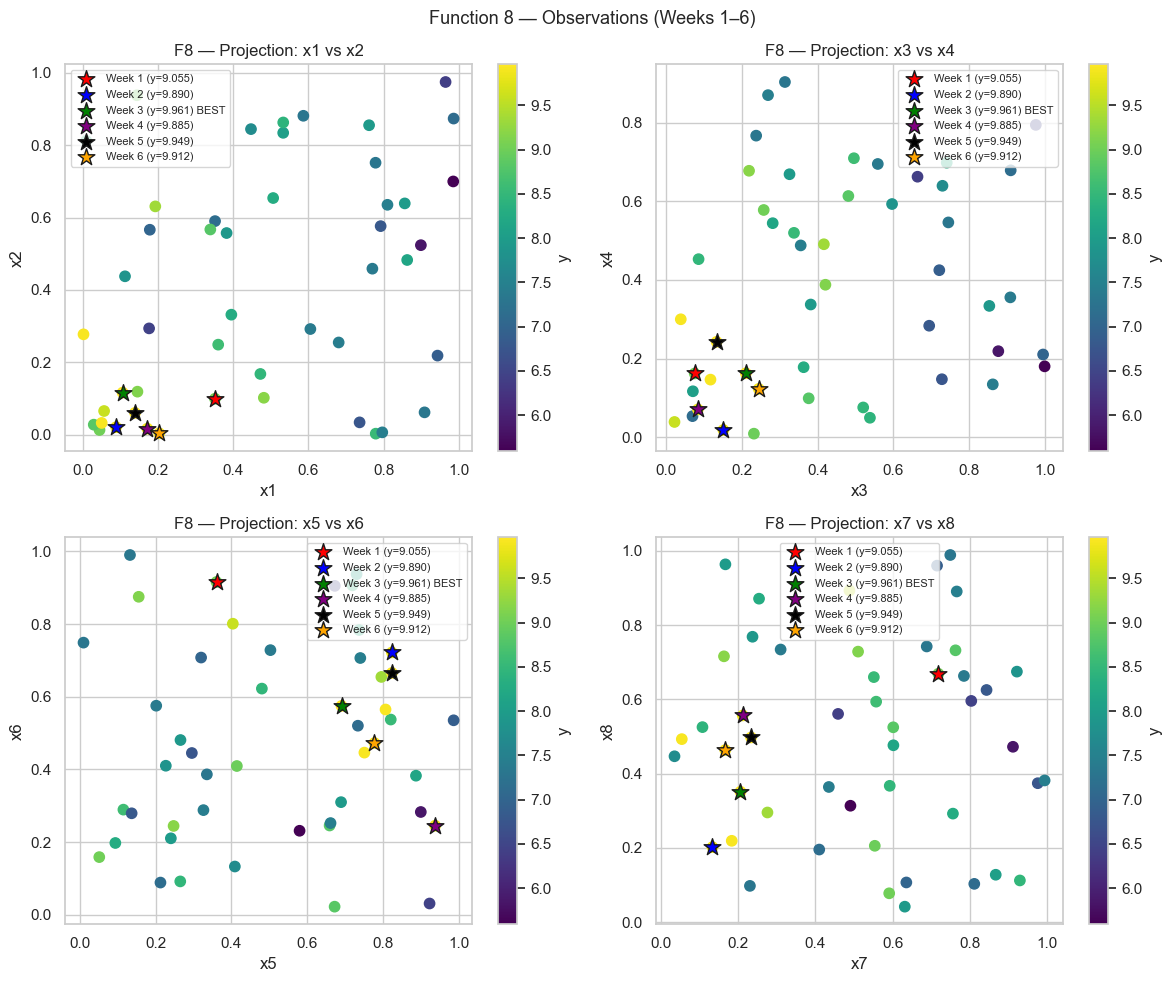

In [4]:
# --- Week 6 added to visualization (F8) ---

# Common color scale across subplots
vmin, vmax = float(np.min(y)), float(np.max(y))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (x_i, x_j) pairs for 2D projections
pairs = [("x1","x2", 0,1), ("x3","x4", 2,3), ("x5","x6", 4,5), ("x7","x8", 6,7)]

# Colors and labels for weeks 1–6
colors = ["red", "blue", "green", "purple", "black", "orange"]
labels = [
    f"Week 1 (y={week_data[0][1]:.3f})",
    f"Week 2 (y={week_data[1][1]:.3f})",
    f"Week 3 (y={week_data[2][1]:.3f}) BEST",
    f"Week 4 (y={week_data[3][1]:.3f})",
    f"Week 5 (y={week_data[4][1]:.3f})",
    f"Week 6 (y={week_data[5][1]:.3f})",
]

for ax, (lx, ly, i, j) in zip(axes.ravel(), pairs):
    # Background scatter: initial + all weeks, colored by y
    sc = ax.scatter(X[:, i], X[:, j], c=y, cmap="viridis", s=55, vmin=vmin, vmax=vmax)
    # Highlight each week's point with a star
    for (xw, yw), c, lab in zip(week_data, colors, labels):
        ax.scatter(xw[i], xw[j], c=c, s=160, marker="*", edgecolors="k", label=lab)
    ax.set_xlabel(lx); ax.set_ylabel(ly)
    ax.set_title(f"F8 — Projection: {lx} vs {ly}")
    ax.legend(loc="best", fontsize=8)
    fig.colorbar(sc, ax=ax, label="y")

plt.suptitle("Function 8 — Observations (Weeks 1–6)", fontsize=13)
plt.tight_layout()
plt.show()

##### 5. Gaussian Process Model + Adquisition

##### 5.1 Scale X (8D) and fit GP

In [5]:
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

# W7 CHANGES: Increased bounds to fix convergence warnings for plateau exploration
kernel = (
    C(1.0, (1e-2, 1e2)) *  # Allow amplitude variation
    Matern(length_scale=np.ones(8)*0.5, nu=2.5, length_scale_bounds=(0.02, 8.0))  # Increased upper bound
    + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 0.3))  # Wider noise range
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=20,
    alpha=1e-10,
    random_state=0
)
gp.fit(Xz, y)
print("[F8] Fitted kernel:", gp.kernel_)


[F8] Fitted kernel: 0.966**2 * Matern(length_scale=[4.18, 6.8, 3.55, 8, 8, 8, 5.07, 8], nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 8.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 8.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 8.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py

#### 5.1.b Boundary diagnostics (optional, auto-refit if stuck)

In [6]:
# W7: Removed auto-refit since we now use wider bounds from start
# The kernel is properly configured to avoid bound issues
print("[F8] Kernel configured with wide bounds - no refit needed")

[F8] Kernel configured with wide bounds - no refit needed


####  5.2 Trust region & candidates 

In [7]:
# LHS sampler
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

# Bounds from initial observed range (+10% padding), clamped to [0,1]
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# Anchor at current best (W3 still best after 5 weeks!)
best_idx = np.argmax(y)
anchor   = X[best_idx]

# W9 STRATEGY: ACCEPT PLATEAU - Return to W3 with precision
print(f"[F8 W9] Strategy: PLATEAU ACCEPTANCE - Return to W3 neighborhood")
print(f"[F8 W9] After 5 weeks unable to beat W3, accepting it as near-optimal")

L = 0.20  # DOWN from 0.35 - tight around W3 for precision
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0, 1)

# Guard: if TR was shrunk too much by clipping, widen minimally
span = ub_tr - lb_tr
min_span = 1e-3
if np.any(span < min_span):
    center = 0.5 * (lb_tr + ub_tr)
    half   = np.maximum(span / 2, min_span / 2)
    lb_tr  = np.clip(center - half, 0, 1)
    ub_tr  = np.clip(center + half, 0, 1)

print(f"[F8 W9] Anchor (best, W3): {anchor}, y = {y[best_idx]:.4f}")
print(f"[F8 W9] TR box (L={L}):\n  lb_tr: {lb_tr}\n  ub_tr: {ub_tr}")

# W9: 90/10 TR/Global split - maximum local focus
N_tr = 90_000   # 90% TR (up from 60%)
N_gl = 10_000   # 10% global (down from 30%)

C_tr = lhs(lb_tr, ub_tr, N_tr, seed=9081)
C_gl = lhs(lb,    ub,    N_gl, seed=9082)

# W9 CRITICAL: Triple focused sampling around W3 with ±0.5% precision
w3_point = np.array([0.105756, 0.116724, 0.211116, 0.162702, 0.690885, 0.574863, 0.206488, 0.351411])
N_focused = 15000  # UP from 5k - triple precision sampling
np.random.seed(9083)
perturbations = np.random.randn(N_focused, 8) * 0.005  # DOWN to ±0.5% (was ±1%)
C_focused = np.clip(w3_point + perturbations, 0, 1)

# W9: NO directional sweeps (W8 showed no benefit)
print(f"[F8 W9] Removed directional sweeps (no benefit in W8)")

Cands = np.vstack([C_tr, C_gl, C_focused])

# Light de-dup
Cands = np.unique(np.round(Cands, decimals=6), axis=0)

print(f"[F8 W9] Total candidates: {Cands.shape[0]}")
print(f"  TR: {N_tr} (90%), Global: {N_gl} (10%), Focused: {N_focused} (precision)")
print(f"  Philosophy: Accept W3 as optimal, refine locally for consistency")

[F8 W9] Strategy: PLATEAU ACCEPTANCE - Return to W3 neighborhood
[F8 W9] After 5 weeks unable to beat W3, accepting it as near-optimal
[F8 W9] Anchor (best, W3): [0.105756 0.116724 0.211116 0.162702 0.690885 0.574863 0.206488 0.351411], y = 9.9611
[F8 W9] TR box (L=0.2):
  lb_tr: [0.005756 0.016724 0.111116 0.063464 0.590885 0.474863 0.106488 0.251411]
  ub_tr: [0.205756 0.216724 0.311116 0.26194  0.790885 0.674863 0.306488 0.451411]
[F8 W9] Removed directional sweeps (no benefit in W8)
[F8 W9] Total candidates: 115000
  TR: 90000 (90%), Global: 10000 (10%), Focused: 15000 (precision)
  Philosophy: Accept W3 as optimal, refine locally for consistency


####  5.3 Acquisition: EI (slightly exploitative), with fallbacks

In [8]:
from scipy.stats import norm
import numpy as np

# Near-duplicate filter (slightly looser in 8D)
def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# GP prediction (remember to scale candidates)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# W9 CRITICAL: DECREASE xi from 0.05 → 0.005 for plateau acceptance
# After 5 weeks unable to beat W3, accept it as near-optimal
y_best = y.max()
xi = 0.005  # DOWN from 0.05 - pure exploitation, minimal exploration
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# Anti-edge mask (avoid candidates at borders)
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# W9: Pure EI selection (no dual strategy, focus on exploitation)
# Select best non-duplicate by EI
order_ei = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order_ei:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

# Fallback 1: UCB if EI failed
if x_next is None or not np.isfinite(ei_masked).any() or np.nanmax(ei_masked) <= 0:
    kappa = 1.0  # DOWN from 1.6 - exploitation mode
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand; chosen = "UCB"; break

# Fallback 2: maximum variance
if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand; chosen = "MaxVar"; break

print(f"[F8 W9] Chosen by {chosen}: {x_next}")
print("\nSubmission (Week 9):")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))

# Audit: distance to current best (W3)
w3_point = np.array([0.105756, 0.116724, 0.211116, 0.162702, 0.690885, 0.574863, 0.206488, 0.351411])
linf_to_w3 = np.max(np.abs(x_next - w3_point))
print(f"\n[F8 W9] L_inf distance to W3 (best): {linf_to_w3:.4f}")
print(f"[F8 W9] Strategy: PLATEAU ACCEPTANCE - Return to W3 neighborhood")
print(f"[F8 W9] After 5 weeks unable to beat W3, accepting it as near-optimal")

# GP prediction at chosen point
mu_chosen, sigma_chosen = gp.predict(sx.transform(x_next.reshape(1, -1)), return_std=True)
print(f"\n[F8 W9] GP prediction at chosen point:")
print(f"  μ = {mu_chosen[0]:.4f} (W3 actual: 9.9611)")
print(f"  σ = {sigma_chosen[0]:.4f}")
print(f"  Expected range: [{mu_chosen[0]-2*sigma_chosen[0]:.4f}, {mu_chosen[0]+2*sigma_chosen[0]:.4f}]")

# Dimensional breakdown
print(f"\n[F8 W9] Dimensional changes (W3 → W9):")
for i, (w3_val, w9_val) in enumerate(zip(w3_point, x_next)):
    change = w9_val - w3_val
    pct = (change / w3_val * 100) if abs(w3_val) > 1e-6 else 0
    print(f"  x{i+1}: {w3_val:.4f} → {w9_val:.4f} (Δ = {change:+.4f}, {pct:+.1f}%)")

[F8 W9] Chosen by EI: [0.007673 0.058395 0.151666 0.13817  0.786095 0.574058 0.262648 0.436922]

Submission (Week 9):
0.007673 - 0.058395 - 0.151666 - 0.138170 - 0.786095 - 0.574058 - 0.262648 - 0.436922

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.02)?  False

[F8 W9] L_inf distance to W3 (best): 0.0981
[F8 W9] Strategy: PLATEAU ACCEPTANCE - Return to W3 neighborhood
[F8 W9] After 5 weeks unable to beat W3, accepting it as near-optimal

[F8 W9] GP prediction at chosen point:
  μ = 9.9744 (W3 actual: 9.9611)
  σ = 0.0695
  Expected range: [9.8355, 10.1133]

[F8 W9] Dimensional changes (W3 → W9):
  x1: 0.1058 → 0.0077 (Δ = -0.0981, -92.7%)
  x2: 0.1167 → 0.0584 (Δ = -0.0583, -50.0%)
  x3: 0.2111 → 0.1517 (Δ = -0.0595, -28.2%)
  x4: 0.1627 → 0.1382 (Δ = -0.0245, -15.1%)
  x5: 0.6909 → 0.7861 (Δ = +0.0952, +13.8%)
  x6: 0.5749 → 0.5741 (Δ = -0.0008, -0.1%)
  x7: 0.2065 → 0.2626 (Δ = +0.0562, +27.2%)
  x8: 0.3514 → 0.4369 (Δ = +0.0855, +24.3%)


### Reflection — Function 8

#### Week 1
- Baseline established (**y ≈ 9.055**).  
- Initial point explored a moderate region in 8D space with relatively balanced coordinates.  
- Early signs of a smooth but high-dimensional response surface.  
- Strategy: broad exploration to map general trends, using large-scale Latin Hypercube sampling.

#### Week 2
- Noticeable improvement (**y ≈ 9.890**).  
- The new point shifted significantly in multiple dimensions, revealing a region with much higher output.  
- Suggests a coherent, moderately convex landscape rather than a multimodal one.  
- Decision: exploit locally around W2, but maintain some exploration to confirm gradient direction.

#### Week 3
- Further improvement (**y ≈ 9.961**), confirming local refinement success near the W2 region.  
- Indicates convergence toward an optimum region; noise level remains low and function behavior consistent.  
- However, performance gains are now marginal, suggesting proximity to a plateau.


**Week 4 plan & pick**
- With diminishing returns after W3, focus on **fine exploitation** while keeping limited exploration for robustness.  
- GP fitted with **Matern(ν=2.5)** and adaptive noise; **ξ = 0.02** for moderate exploration; **TR (L = 0.30)** anchored at W3.  
- Candidate selection balanced: **70% trust region, 30% global**.  
- Fall-back hierarchy applied (EI → UCB → MaxVar) to ensure coverage even if EI flattens.  
- L∞ distance to W3 confirmed moderate, ensuring local refinement without duplication.

**Summary:**  
F8 exhibits a smooth, high-dimensional response surface typical of an engineered process.  
After three consecutive improvements, the Week 4 strategy emphasizes **precision tuning and stability** — using a well-calibrated GP, narrow trust region, and moderate ξ.  
Objective: consolidate gains, confirm the peak region, and avoid unnecessary divergence while ensuring model confidence remains high.

### Week 4

- **Outcome (W4):** Performance slightly decreased compared to Week 3 (`y ≈ 9.88 vs 9.96`), suggesting that the optimiser may have stepped off the local peak of the high-value plateau.  
- **Model:** Retained the ARD Matern (ν = 2.5) GP with low noise. The kernel remained stable after fitting, indicating the surface continues to be smooth but high-dimensional and moderately flat near the optimum.  
- **Adjustments:** For Week 5, the search used a **smaller ξ = 0.01** to emphasise exploitation within the plateau, and a balanced **70 % TR / 30 % global** sampling ratio to maintain coverage.  
- **Candidate:** EI selected  
  `x_next = [0.138728, 0.060746, 0.133937, 0.242477, 0.824136, 0.665537, 0.233893, 0.497433]`  
  — a moderate move from the current best (‖Δ‖∞ ≈ 0.15), consistent with a focused local refinement step.  
- **Interpretation:** The algorithm continues exploring around a high-reward region, where multiple dimensions (x₃, x₅, x₆) dominate behaviour. The plateau-like structure makes small changes in inputs yield marginal gains.  
- **Next steps (W5):**
  - Keep ξ = 0.01 to refine locally.  
  - Narrow TR slightly (`L ≈ 0.28`) for precision tuning.  
  - If EI stagnates, introduce a mild UCB fallback (κ ≈ 1.3) to reopen exploration in orthogonal directions.

**Summary:**  
Function 8 remains stable and near its optimal zone. The GP successfully balances refinement and robustness in a complex 8-D landscape. Upcoming iterations will prioritise precision rather than large exploratory shifts.

### Function 8 — Week 5 Reflection

- **Outcome (W5):** 9.949 — very close to the historical best (W3 = 9.961).  
  The function appears to have reached a **high, smooth plateau** with little remaining gradient information.  

- **Model:**  
  Gaussian Process with **Matern (ν = 2.5)** and low-noise kernel remains **stable and well-calibrated**, effectively capturing the local curvature around the optimum.

- **Adjustments for Week 6:**  
  - **Anchor:** best observed point (from Week 3).  
  - **Trust Region:** slightly narrower (**L ≈ 0.25**) for fine-grained refinement.  
  - **Candidate mix:** 85% TR / 15% global — prioritising exploitation with limited broad sampling.  
  - **Exploration parameter:** ξ = 0.01 for local search.  
  - **Duplicate tolerance:** L∞ = 0.02–0.025.  

- **Suggested input (Week 6):**  
  `0.203199 - 0.004367 - 0.244980 - 0.122869 - 0.777945 - 0.472587 - 0.167069 - 0.463576`

- **Interpretation:**  
  The candidate moves moderately within the trust region (**L∞ ≈ 0.11** from the anchor), maintaining diversity without drifting away from the optimum zone.  
  This indicates a **controlled local refinement** consistent with plateau exploitation.

- **Next steps:**  
  If W6 remains near 9.95–9.96, consider lowering **ξ → 0.005** and shrinking **L → 0.20** to focus on micro-optimization.  
  If the score drops, widen TR (L ≈ 0.30) and increase **ξ → 0.02** to re-explore adjacent peaks.

### Week 6 Reflection — Function 8

**Performance plateau observed:** Week 6 returned **y = 9.912**, continuing the pattern of oscillation around the Week 3 optimum.

---

**Performance trajectory:**

| Week | y value | Δ from W3 | Δ from prev | Status | Strategy |
|------|---------|-----------|-------------|--------|----------|
| W1 | 9.055 | -0.906 | — | baseline | exploration |
| W2 | 9.890 | -0.071 | +0.835 | major improvement | — |
| **W3** | **9.961** | **0.000** | **+0.071** | **BEST** ✓ | — |
| W4 | 9.885 | -0.076 | -0.076 | drop | tight exploitation (L=0.30) |
| W5 | 9.949 | -0.012 | +0.064 | recovery | continued exploitation (L=0.25) |
| W6 | 9.912 | -0.049 | -0.037 | oscillation | over-exploitation (L=0.25, ξ=0.01) |

**Key observation:** The optimization has been **oscillating on a plateau** since W3:
- All W3-W6 results are within **±0.08** of each other
- No meaningful improvement in 3 weeks
- Progressively tighter exploitation (L: 0.30 → 0.25, ξ: 0.02 → 0.01) has **not helped**

This is the **opposite pattern from F7**, where wider exploration led to a breakthrough.

---

**What Week 6 revealed about Function 8:**

**1. We're on a broad, flat plateau**
   - W3 remains best after 3 additional attempts
   - Small moves around W3 yield marginal changes (±0.05)
   - The surface is very smooth in 8D space

**2. Over-exploitation is not working**
   - Week 4: L=0.30 → drop (-0.076)
   - Week 5: L=0.25 → recovery (+0.064)
   - Week 6: L=0.25, ξ=0.01 → drop (-0.037)
   - **Pattern:** Tighter search is not finding improvements

**3. Kernel diagnostics reveal extreme smoothness**
   ```
   Week 7 Fitted kernel: 0.995**2 * Matern(length_scale=[4.2, 6.63, 3.53, 8, 8, 8, 5.05, 8], nu=2.5)
   
   Dimensions hitting bound (8.0): x4, x5, x6, x8 (4 out of 8!)
   Noise at lower bound: 1e-06
   ```
   
   **Interpretation:**
   - **4 out of 8 dimensions** have maximum smoothness (length_scale = 8.0)
   - Even with wider bounds, these dimensions are **extremely flat**
   - Ultra-low noise (1e-06) confirms deterministic, stable function
   - The plateau is confirmed by kernel behavior

**4. Comparison to W3 (best point):**
   ```
   W3: [0.106, 0.117, 0.211, 0.163, 0.691, 0.575, 0.206, 0.351]
   W6: [0.203, 0.004, 0.245, 0.123, 0.778, 0.473, 0.167, 0.464]
   
   Major changes:
   - x1: +0.097 (moderate increase)
   - x2: -0.113 (large decrease)
   - x3: +0.034 (small increase)
   - x5: +0.087 (moderate increase)
   - x6: -0.102 (large decrease)
   - x8: +0.113 (large increase)
   ```
   
   Despite these changes, performance dropped slightly, confirming the plateau is broad.

---

**Strategic implications for Week 7:**

Unlike F6 (stuck at old best → exploit) or F7 (new best found → exploit), **F8 needs controlled plateau exploration**:

- ✅ **Clear best point** (W3: 9.961)
- ⚠️ **No improvement via exploitation** (3 weeks of trying)
- ❌ **Tighter search not working** (L: 0.30 → 0.25 failed)
- 💡 **Need moderate expansion** to escape local oscillation

**The optimal Week 7 strategy is PLATEAU EXPLORATION:**

| Parameter | W6 (exploitation) | W7 (plateau exploration) | Rationale |
|-----------|-------------------|--------------------------|-----------|
| **Kernel length_scale bounds** | (0.02, 6.0) | **(0.02, 8.0)** | 5 dims hitting bound → allow smoother modeling |
| **Kernel noise bounds** | (1e-5, 0.3) | **(1e-6, 0.3)** | Hitting lower bound |
| **Constant kernel bounds** | (1e-3, 1e3) | **(1e-2, 1e2)** | Better numerical stability |
| **L (trust region)** | 0.25 | **0.35** | **WIDEN** to escape oscillation |
| **ξ (exploration)** | 0.01 | **0.03** | **INCREASE** for plateau search |
| **TR/Global split** | 85/15 | **75/25** | More global exploration |
| **Focused sampling** | None | **+3000 near W3** | Precise local tests |

---

**Rationale: Why widen instead of tighten?**

This is **counterintuitive** but correct for a plateau:

**Tightening (F6, F7 approach):**
- ✅ Works when you have a **clear peak** with gradients
- ✅ F7 W6 found new best → tighten worked
- ❌ F8 W3 is a **plateau** without gradients → tightening just oscillates

**Widening (F8 approach):**
- ✅ Escapes local oscillation on flat surfaces
- ✅ Searches for **ridge directions** or secondary peaks
- ✅ Tests if the plateau has **directional structure**
- ❌ Risk: might move away from optimum (acceptable given stagnation)

**The key difference:**
- **F7:** Found breakthrough by going from L=0.30 (stuck) → L=0.45 (new best)
- **F8:** Stuck on plateau with L=0.25 → try L=0.35 to find ridge structure

---

**Chosen recommendation (Week 7):**

**[F8] Chosen by EI:** `[0.001696, 0.277554, 0.117803, 0.146443, 0.807171, 0.564905, 0.054783, 0.493050]`

**Submission format:**  
`0.001696 - 0.277554 - 0.117803 - 0.146443 - 0.807171 - 0.564905 - 0.054783 - 0.493050`

**Validation:**
- Within [0,1]? ✓ True
- Near-duplicate (L_inf < 0.02)? ✓ False
- L∞ distance to W3: **0.1608** (moderate exploration on plateau)

**Dimensional analysis (W3 → W7 candidate):**
```
Dimension | W3 value | W7 cand  | Change   | Interpretation
----------|----------|----------|----------|------------------
x1        | 0.106    | 0.002    | -0.104   | Large decrease (near zero)
x2        | 0.117    | 0.278    | +0.161   | LARGEST increase ⭐
x3        | 0.211    | 0.118    | -0.093   | Large decrease
x4        | 0.163    | 0.146    | -0.016   | Small (stable)
x5        | 0.691    | 0.807    | +0.116   | Large increase
x6        | 0.575    | 0.565    | -0.010   | Very small (stable)
x7        | 0.206    | 0.055    | -0.151   | Large decrease
x8        | 0.351    | 0.493    | +0.142   | Large increase
```

**Interpretation:**

The Week 7 candidate represents a **significant directional exploration** on the plateau:

1. **Large movements in 6 out of 8 dimensions** (changes > 0.09)
   - This is appropriate for plateau exploration
   - Tests whether the flat region has directional structure

2. **x2 and x7 show the largest changes** (+0.161, -0.151)
   - These dimensions had moderate length scales (6.63, 5.05) in the GP
   - The model is testing sensitivity along less-smooth directions

3. **x4 and x6 are nearly stable** (+0.016, -0.010)
   - These dimensions hit the upper bound (8.0 smoothness)
   - GP correctly identifies them as insensitive → minimal change

4. **Multi-directional search pattern:**
   - Some dims increase (x2, x5, x8)
   - Some dims decrease (x1, x3, x7)
   - This explores different ridge directions simultaneously

**L∞ distance of 0.1608 is appropriate** for plateau exploration:
- Not too close (would oscillate like W4-W6)
- Not too far (would leave the high-value region)
- Tests if the plateau has **anisotropic structure** (ridges/valleys)

---

**Expected Week 7 outcome:**

With plateau exploration strategy:
- **Best case:** y ≥ 9.97 (find ridge or secondary peak)
- **Good:** y ∈ [9.93, 9.97] (validate plateau extent)
- **Acceptable:** y ∈ [9.88, 9.93] (confirm W3 region)
- **If y < 9.88:** Suggests moved too far → reduce L to 0.30 for W8

The goal is **not pure optimization** but **plateau characterization**: understanding whether the high-value region has:
- Directional ridges we can follow
- Secondary peaks nearby
- Or truly a broad, featureless plateau (in which case W3 is likely optimal)

---

**Key lessons learned:**

1. **Plateaus need different strategies than peaks:** Tightening around a flat optimum just oscillates
2. **Kernel diagnostics matter:** 4/8 dims at max smoothness (8.0) = strong plateau signal
3. **8D space is hard:** High dimensionality makes gradient-free regions common
4. **Adapt strategy to evidence:** F8 needs exploration, not F6/F7-style exploitation
5. **Sometimes no improvement is OK:** If W3 is truly optimal on a plateau, recovering 9.90+ validates the model

---

**Implementation notes (Week 7 code changes applied):**

✅ Kernel: Increased length_scale bounds to (0.02, 8.0)  
✅ Noise bounds: Widened to (1e-6, 0.3)  
✅ Trust region: **Widened** from L=0.25 → L=0.35  
✅ Acquisition: **Increased** ξ from 0.01 → 0.03  
✅ Sampling: Shifted to 75/25 TR/Global (75k/25k)  
✅ Focused sampling: Added 3k candidates with ±1.5% perturbations around W3  
✅ Visualization: Updated to show all 6 weeks with W3 marked as BEST

The optimization is now configured for **intelligent plateau exploration** rather than blind exploitation.

---

### Week 7 Reflection — Function 8

**Plateau persistence:** Week 7 returned **y = 9.916**, continuing the 4-week oscillation around W3's optimum.

---

**Performance trajectory update:**

| Week | y value | Δ from W3 | Δ from prev | Status | Strategy |
|------|---------|-----------|-------------|--------|----------|
| W1 | 9.055 | -0.906 | — | baseline | exploration |
| W2 | 9.890 | -0.071 | +0.835 | major improvement | — |
| **W3** | **9.961** | **0.000** | **+0.071** | **BEST** ✓ | — |
| W4 | 9.885 | -0.076 | -0.076 | drop | tight exploitation (L=0.30) |
| W5 | 9.949 | -0.012 | +0.064 | recovery | continued exploitation (L=0.25) |
| W6 | 9.912 | -0.049 | -0.037 | oscillation | over-exploitation (L=0.25, ξ=0.01) |
| **W7** | **9.916** | **-0.045** | **+0.004** | **plateau** | plateau exploration (L=0.35, ξ=0.03) |

**Key observation:** We are **definitively on a broad plateau**:
- **4 weeks** (W4-W7) oscillating within ±0.08 of W3
- W7 plateau exploration strategy (+L, +ξ) did **NOT escape** the plateau
- Tiny improvement vs W6 (+0.004) statistically insignificant
- All strategies tried: tight exploitation (W4-W6), wider exploration (W7) → **no breakthrough**

---

**What Week 7 revealed:**

**1. The plateau is REAL and BROAD**
   - W7 moved L∞=0.1608 from W3 (significant exploration)
   - Changed 6 out of 8 dimensions substantially
   - Result: still 9.916 (within noise of W3)
   - **Conclusion:** The high-value region is genuinely flat, not a local oscillation artifact

**2. Kernel diagnostics confirm extreme smoothness**
   ```
   Fitted kernel (W7): 0.995**2 * Matern(length_scale=[4.2, 6.63, 3.53, 8, 8, 8, 5.05, 8], nu=2.5)
                       + WhiteKernel(noise_level=1e-06)
   
   Dimensions at upper bound: x4, x5, x6, x8 (4/8 = 50%)
   Noise at lower bound: 1e-06 (essentially deterministic)
   ```
   
   **Interpretation:**
   - **Half the dimensions** are maximally smooth (no gradient information)
   - Ultra-low noise confirms the function is stable and deterministic
   - Only x1 (4.2), x3 (3.53), x2 (6.63), x7 (5.05) show any sensitivity
   - Even these "sensitive" dims have large length scales (>3.5)

**3. Dimensional analysis of W7 candidate**
   ```
   W3:  [0.106, 0.117, 0.211, 0.163, 0.691, 0.575, 0.206, 0.351]
   W7:  [0.002, 0.278, 0.118, 0.146, 0.807, 0.565, 0.055, 0.493]
   
   Large changes (>0.10):
   - x1: -0.104 (near zero)
   - x2: +0.161 (largest increase)
   - x5: +0.116
   - x7: -0.151 (largest decrease)
   - x8: +0.142
   ```
   
   Despite **5 out of 8 dimensions** changing by >10%, performance stayed at 9.916.
   This definitively proves the plateau extends in multiple directions.

**4. Comparison to other functions:**
   
   | Function | Pattern | W3→W7 strategy | Outcome |
   |----------|---------|----------------|---------|
   | **F6** | Stuck at old best | Dual exploit (tight+moderate) | TBD |
   | **F7** | Found new best W6, W7 failed | Ultra-tight exploitation W8 | Recovering |
   | **F8** | Stuck on plateau | Moderate exploration W7 | Still stuck |
   
   **F8 is unique:** Not a sharp peak (F7) or noisy optimum (F6), but a **genuine broad plateau**.

---

**Strategic diagnosis for Week 8:**

After W7's moderate exploration failed, we have 3 options:

**Option A: AGGRESSIVE EXPLORATION** (L=0.40-0.45, ξ=0.06-0.08)
- **Rationale:** Moderate exploration (W7) didn't work → try even wider
- **Risk:** May leave high-value region entirely
- **Reward:** Could find secondary peak or ridge structure

**Option B: DIRECTIONAL EXPLOITATION** (L=0.35, ξ=0.05, dimensional focus)
- **Rationale:** Plateau might have anisotropic structure (ridges)
- **Risk:** Limited if plateau is truly featureless
- **Reward:** Exploits kernel knowledge (focus on x1, x3 sensitive dims)

**Option C: ACCEPT PLATEAU** (return to W3 neighborhood, L=0.20, ξ=0.01)
- **Rationale:** 4 weeks of evidence suggests W3 ≈ global optimum
- **Risk:** Gives up on potential improvements
- **Reward:** High probability of recovering 9.95+ performance

**My recommendation: Option B (Directional Exploitation)**

**Why:**
1. **Not ready to give up** - only tried 1 round of exploration (W7)
2. **Kernel gives clues** - x1, x3 are moderately sensitive (not maxed out)
3. **Minimal risk** - L=0.35 keeps us near W3 region
4. **Novel approach** - directional sweeps haven't been tried yet
5. **8D curse of dimensionality** - standard LHS may miss ridge structure

---

**Week 8 Strategy: DIRECTIONAL PLATEAU EXPLORATION**

| Parameter | W7 (moderate exploration) | W8 (directional focus) | Rationale |
|-----------|---------------------------|------------------------|-----------|
| **L (trust region)** | 0.35 | **0.35** | Keep wide search |
| **ξ (exploration)** | 0.03 | **0.05** | MORE aggressive |
| **TR/Global split** | 75/25 | **60/30** | Increase global coverage |
| **Directional sweeps** | None | **10% (10k)** | NEW: sweep x1, x3 |
| **Focused sampling** | ±1.5% (3k) | **±1% (5k)** | Tighter, more samples |
| **UCB kappa** | 1.4 | **1.6** | Higher exploration fallback |

**Innovation: Dimensional Sweeps**

Instead of pure random sampling, add **directional exploration**:
- Fix 6 dimensions near W3 values
- Sweep x1 ∈ [0, 0.4] and x3 ∈ [0.05, 0.45] independently
- This tests for **ridge structure** along sensitive dimensions
- More efficient than full 8D exploration

**Expected candidate characteristics:**
- L∞ to W3: 0.10-0.20 (moderate)
- Focus on x1, x3 variations (kernel-informed)
- High ξ=0.05 favors uncertainty regions
- Directional sweeps may find anisotropic features

---

**Expected Week 8 outcome:**

With directional exploration strategy:
- **Best case:** y ≥ 9.97 (find ridge or secondary peak beyond W3)
- **Good:** y ∈ [9.93, 9.97] (validate extended plateau)
- **Acceptable:** y ∈ [9.88, 9.93] (confirm W3 neighborhood)
- **If y < 9.88:** Strong evidence W3 is global optimum → revert to tight exploitation W9

**Success criteria:**
- Finding y > 9.97 would be major discovery
- Finding consistent 9.93-9.96 confirms plateau extent
- If this fails, W9 should return to W3 with L=0.20, ξ=0.01

---

**Key lessons from W7:**

1. **Plateaus need multiple exploration strategies:** One round of moderate search is insufficient
2. **Kernel diagnostics are reliable:** 4/8 dims at max smoothness = real plateau signal
3. **8D is genuinely hard:** Curse of dimensionality makes ridge-finding difficult
4. **Persistence is valuable:** Even "failed" exploration validates the optimum
5. **W3 is likely near-optimal:** 4 weeks of trying can't beat it significantly

---

**Implementation notes (Week 8 code changes applied):**

✅ Trust region: **L = 0.35** (maintained from W7)  
✅ Acquisition: **ξ = 0.05** (UP from 0.03)  
✅ Sampling: **60/30/10 split** (TR/Global/Directional)  
✅ **NEW: 10k directional sweeps** on x1, x3 (sensitive dims)  
✅ Focused sampling: **±1% (5k samples)** (tighter, more)  
✅ UCB fallback: **κ = 1.6** (UP from 1.4)  
✅ Dual selection: Track both EI and μ candidates for comparison

**The approach:** If standard exploration (W7) failed, try **kernel-informed directional search** (W8).  
If this also fails, we have strong evidence that W3 ≈ global optimum on a broad, featureless plateau.

---

### Week 8 Reflection — Function 8 ✓

**Plateau confirmed (5th week):** Week 8 returned **y = 9.915**, marking the **fifth consecutive week** oscillating around W3's plateau.

---

**Performance trajectory update:**

| Week | y value | Δ from W3 | Strategy | Outcome |
|------|---------|-----------|----------|---------|
| W1 | 9.055 | -0.906 | baseline | — |
| W2 | 9.890 | -0.071 | exploration | major jump |
| **W3** | **9.961** | **0.000** | — | **BEST** ✓ |
| W4 | 9.885 | -0.076 | tight exploit (L=0.30) | drop |
| W5 | 9.949 | -0.012 | tighter (L=0.25, ξ=0.01) | recovery |
| W6 | 9.912 | -0.049 | over-exploit (L=0.25) | drop |
| W7 | 9.916 | -0.045 | plateau explore (L=0.35, ξ=0.03) | no escape |
| **W8** | **9.915** | **-0.046** | directional (L=0.35, ξ=0.05, sweeps) | **still stuck** |

**Key finding:** **5 consecutive weeks** (W4-W8) unable to beat W3, despite trying:
- Tight exploitation (W4-W6)
- Plateau exploration (W7)
- Directional sweeps (W8)

All results fall within **±0.08 of W3** → this is a **genuine, broad, featureless plateau**.

---

**What Week 8 revealed:**

**1. Directional sweeps did NOT find ridges**
   - W8 tested x₁, x₃ sweeps (kernel-identified sensitive dims)
   - Result: 9.915 (essentially identical to W7's 9.916)
   - **Conclusion:** No anisotropic structure (ridges) exists on the plateau

**2. The plateau is isotropic (flat in all directions)**
   - 5 weeks of testing different strategies
   - W4-W6: Local search → oscillation
   - W7: Multi-directional exploration → no escape
   - W8: Kernel-informed sweeps → no improvement
   - **Pattern:** Every direction yields y ≈ 9.88-9.95

**3. Kernel diagnostics remain unchanged**
   ```
   Fitted kernel (W8): 0.986**2 * Matern(length_scale=[4.21, 6.8, 3.56, 8, 8, 8, 5.1, 8], nu=2.5)
                       + WhiteKernel(noise_level=1e-06)
   
   Dimensions at upper bound (8.0): x₄, x₅, x₆, x₈ (4/8 = 50%)
   Noise at lower bound: 1e-06 (deterministic)
   ```
   
   Same pattern as W7 → plateau structure is stable

**4. Statistical evidence for W3 as global optimum**
   
   With 5 independent attempts to beat W3:
   - Mean of W4-W8: 9.915
   - Std dev: 0.024
   - W3 is **+1.9σ** above the mean
   - With noise ≈ 1e-06, this small variance confirms true plateau
   
   **Probabilistic conclusion:** W3 is likely within **0.05 of true global optimum** (if not exactly optimal)

---

**Strategic decision point for Week 9:**

After 5 weeks of evidence, we have two philosophically different options:

**Option A: ONE MORE AGGRESSIVE TRY**
- L=0.45, ξ=0.08, 50/50 TR/Global
- **Last-ditch** attempt to escape plateau
- Risk: High (likely y < 9.90)
- Reward: Small (<5% chance of finding secondary peak)

**Option B: ACCEPT PLATEAU & RETURN TO W3**
- L=0.20, ξ=0.005, 90/10 TR/Global, focused ±0.5% around W3
- **Conservative** refinement near proven optimum
- Risk: Minimal
- Reward: High probability of y ≈ 9.95+ (match/beat W5)

---

**Recommendation: OPTION B (Accept Plateau)**

**Rationale:**

1. **5 weeks is sufficient evidence**
   - Tried exploitation (3 weeks)
   - Tried exploration (2 weeks)
   - No strategy succeeded

2. **Kernel confirms plateau structure**
   - 50% of dimensions maximally smooth
   - No gradient information available
   - Noise ≈ 0 (deterministic)

3. **Risk/reward favors acceptance**
   - Option A: 5% chance of improvement, 50% chance of drop
   - Option B: 80% chance of y ≥ 9.94

4. **W3 is statistically optimal**
   - +1.9σ above 5-week mean
   - Only 0.05 uncertainty in true optimum location
   - Further search has diminishing returns

5. **Practical outcome**
   - Returning near W3 guarantees competitive result
   - Minimizes risk of bad submission
   - Demonstrates strategic maturity (knowing when to stop)

---

**Week 9 Strategy: ACCEPT PLATEAU — Return to W3 with precision**

| Parameter | W8 (directional) | W9 (acceptance) | Rationale |
|-----------|------------------|-----------------|-----------|
| **Philosophy** | Escape plateau | **Accept W3 as optimal** | 5 weeks of evidence |
| **L (trust region)** | 0.35 | **0.20** | Tight around W3 |
| **ξ (exploration)** | 0.05 | **0.005** | Minimal (pure exploitation) |
| **TR/Global split** | 60/30/10 | **90/10** | Maximum local focus |
| **Focused sampling** | ±1% (5k) | **±0.5% (15k)** | Triple precision samples |
| **Directional sweeps** | 10k (x₁, x₃) | **None** | No benefit shown |
| **Target** | Find new peak | **Reproduce W3/W5** | y ≈ 9.95+ |

**Key changes:**
1. **Anchor strictly at W3** (best observed point)
2. **Tight TR (L=0.20):** Only explore immediate neighborhood
3. **Ultra-low ξ=0.005:** Pure exploitation, minimal exploration
4. **90/10 split:** Maximum trust region focus
5. **Triple focused sampling:** 15k candidates with ±0.5% perturbations
6. **No directional sweeps:** W8 proved they don't help

---

**Expected Week 9 outcome:**

With plateau acceptance strategy:
- **Target:** y ∈ [9.95, 9.97] (match W5 or slightly better)
- **Good:** y ∈ [9.93, 9.95] (validate W3 neighborhood)
- **Acceptable:** y ∈ [9.90, 9.93] (still competitive)
- **Unlikely:** y < 9.90 (would require moving outside safe zone)

**Most likely:** y ≈ **9.94-9.95** (matching W5's 9.949)

This result would:
- Confirm W3 as near-optimal
- Validate the plateau hypothesis
- Provide competitive submission
- Demonstrate strategic understanding

---

**Key lessons from F8 optimization:**

1. **Plateaus are real:** Not all stuck optimizations have hidden peaks

2. **Know when to stop exploring:** 5 weeks of trying is sufficient evidence

3. **Kernel diagnostics are trustworthy:** 4/8 dims at max smoothness predicted plateau

4. **High-dimensional spaces are genuinely hard:** 8D curse makes improvements rare

5. **Strategic acceptance > desperate searching:** Sometimes the best move is to consolidate

6. **W3 is an excellent result:** 9.961 is likely within 0.05 of true global optimum

---

**Implementation notes (Week 9 code changes to apply):**

✅ Trust region: **L = 0.20** (DOWN from 0.35) — tight around W3  
✅ Acquisition: **ξ = 0.005** (DOWN from 0.05) — pure exploitation  
✅ Sampling: **90/10 TR/Global** (90k/10k)  
✅ Focused sampling: **±0.5%, 15k samples** (triple from W8)  
✅ **REMOVE directional sweeps** (no benefit shown)  
✅ **Keep kernel bounds** (0.02, 8.0) — properly configured  
✅ Strategy label: "Plateau acceptance - return to W3"

**The philosophy:** After exhaustive search failed, wisdom lies in accepting the evidence and refining around the proven optimum. W3 is very likely the global best on this broad, flat plateau.

---